# ***V2.0: Adicionado Grid Search***

In [1]:
#!pip install ultralytics opencv-python pillow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ---------- Bibliotecas ----------

import os
import shutil
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import yaml
import numpy as np
import cv2
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import timm
from sklearn.metrics import accuracy_score, f1_score
from itertools import product
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
path = os.getcwd()
print(path)

#os.chdir(path)
#file_log = open(path + "/mensagem_final_classificar_V2.txt", "a")

/content


In [5]:
# ================= Configurações =================
NUM_CLASSES = 15
INPUT_SIZE = 224
BATCH_SIZE = 16
# EPOCHS = 30  # ← REMOVER (agora vem do grid search)
# LR = 1e-3    # ← REMOVER (agora vem do grid search)
PATIENCE = 2 #5

#FUSION_MODE = "concat"  # "concat" OU "sum"
FUSION_MODE = "sum"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET_FOLHA = "/content/drive/MyDrive/TCC/Datasets/Imagens Folhas/Especies"
DATASET_CASCA = "/content/drive/MyDrive/TCC/Datasets/Imagens tronco/EspeciesCascas"

PESOS_FOLHA = "/content/drive/MyDrive/TCC/Datasets/main_weights/Folha/mobilenetv4_best_leaf.pt"
PESOS_CASCA = "/content/drive/MyDrive/TCC/Datasets/main_weights/Casca/mobilenetv4_best_bark.pt"

CKPT_DIR = "/content/drive/MyDrive/TCC/Datasets/checkpointsHybridFeature"
FINAL_PATH = "/content/drive/MyDrive/TCC/Datasets/main_weights/hybrid_mobilenet_best.pt"
FINAL_DIR = "/content/drive/MyDrive/TCC/Datasets/main_weights"

os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(FINAL_DIR, exist_ok=True)

In [6]:
def stratified_split(dataset, test_split=0.1, valid_split=0.2, seed=42):
    labels = [label for *_, label in dataset.samples]

    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_split,
        random_state=seed
    )
    train_valid_idx, test_idx = next(
        sss1.split(np.zeros(len(labels)), labels)
    )

    labels_train_valid = np.array(labels)[train_valid_idx]

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=valid_split,
        random_state=seed
    )
    train_idx, valid_idx = next(
        sss2.split(np.zeros(len(labels_train_valid)), labels_train_valid)
    )

    train_idx = np.array(train_valid_idx)[train_idx]
    valid_idx = np.array(train_valid_idx)[valid_idx]

    train_ds = torch.utils.data.Subset(dataset, train_idx)
    valid_ds = torch.utils.data.Subset(dataset, valid_idx)
    test_ds  = torch.utils.data.Subset(dataset, test_idx)

    return train_ds, valid_ds, test_ds

In [7]:
# ================= Dataset =================
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(classes)}

        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_path):
                continue
            for f in os.listdir(cls_path):
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(cls_path, f),
                                         self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def preprocess(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        img = img.astype(np.float32) / 255.0

        mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
        img = (img - mean) / std

        img = np.transpose(img, (2, 0, 1))
        return torch.from_numpy(img)

class CartesianFusionDataset(Dataset):
    def __init__(self, ds_folha, ds_casca):
        self.samples = []

        # Extrair samples considerando Subset
        def get_samples(ds):
            if isinstance(ds, torch.utils.data.Subset):
                # Pegar apenas os índices do subset
                base_samples = ds.dataset.samples
                return [base_samples[i] for i in ds.indices]
            else:
                return ds.samples

        folha_samples = get_samples(ds_folha)
        casca_samples = get_samples(ds_casca)

        # Agrupar por classe
        folhas_por_classe = {}
        cascas_por_classe = {}

        for img, label in folha_samples:
            if label not in folhas_por_classe:
                folhas_por_classe[label] = []
            folhas_por_classe[label].append(img)

        for img, label in casca_samples:
            if label not in cascas_por_classe:
                cascas_por_classe[label] = []
            cascas_por_classe[label].append(img)

        # Produto cartesiano por classe
        for label in folhas_por_classe.keys():
            if label not in cascas_por_classe:
                continue
            for f_img in folhas_por_classe[label]:
                for c_img in cascas_por_classe[label]:
                    self.samples.append((f_img, c_img, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        folha_path, casca_path, label = self.samples[idx]

        # Preprocessar imagens
        img_f = self.preprocess(folha_path)
        img_c = self.preprocess(casca_path)

        return img_f, img_c, torch.tensor(label, dtype=torch.long)

    def preprocess(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        img = img.astype(np.float32) / 255.0

        mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
        img = (img - mean) / std

        img = np.transpose(img, (2, 0, 1))
        return torch.from_numpy(img)

In [8]:
# ================= Feature Extractors =================
def create_feature_extractor(weight_path):
    # 1. Carregar modelo COMPLETO primeiro
    model_full = timm.create_model(
        'mobilenetv4_conv_small.e1200_r224_in1k',
        pretrained=False,
        num_classes=15  # ← MESMO número do treinamento
    )
    model_full.load_state_dict(torch.load(weight_path, map_location=DEVICE, weights_only=False))

    # 2. Criar feature extractor
    model = timm.create_model(
        'mobilenetv4_conv_small.e1200_r224_in1k',
        pretrained=False,
        num_classes=0  # ← Sem classifier
    )

    # 3. Copiar pesos do backbone (tudo exceto classifier)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in model_full.state_dict().items() if k in model_dict}
    model.load_state_dict(pretrained_dict)

    # 4. Congelar
    for p in model.parameters():
        p.requires_grad = False
    model.eval()

    return model.to(DEVICE)

In [9]:
# ================= MLP =================
class FusionMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
# ================= Avaliação =================
@torch.no_grad()
def evaluate(model_f, model_c, mlp, loader):
    mlp.eval()
    preds, labels_all = [], []
    inference_times = []  # ← NOVO

    for img_f, img_c, labels in loader:
        img_f, img_c = img_f.to(DEVICE), img_c.to(DEVICE)

        # ← NOVO: Medir tempo
        start_time = time.time()

        feat_f = model_f(img_f)
        feat_c = model_c(img_c)

        fused = torch.cat([feat_f, feat_c], 1) if FUSION_MODE == "concat" else feat_f + feat_c
        out = mlp(fused)

        end_time = time.time()
        batch_time = end_time - start_time
        inference_times.append(batch_time / img_f.size(0))  # Tempo por imagem

        preds.extend(torch.argmax(out, 1).cpu().numpy())
        labels_all.extend(labels.numpy())

    acc = accuracy_score(labels_all, preds)
    f1 = f1_score(labels_all, preds, average="weighted")
    avg_time = np.mean(inference_times) * 1000  # ← NOVO: em milissegundos

    return acc, f1, avg_time, preds, labels_all  # ← NOVO: retorna tempo, preds e labels

In [11]:
# ================= Funções de Análise =================
def plot_confusion_matrix(y_true, y_pred, class_names, title="Matriz de Confusão", normalize=False):
    """
    Plota matriz de confusão com visualização aprimorada.

    Args:
        y_true: Labels verdadeiros
        y_pred: Predições do modelo
        class_names: Lista com nomes das classes
        title: Título do gráfico
        normalize: Se True, normaliza os valores por linha (%)
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
    else:
        fmt = 'd'

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Porcentagem' if normalize else 'Contagem'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Classe Verdadeira', fontsize=12)
    plt.xlabel('Classe Predita', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def print_per_class_accuracy(y_true, y_pred, class_names):
    """
    Imprime acurácia por classe e outras métricas detalhadas.

    Args:
        y_true: Labels verdadeiros
        y_pred: Predições do modelo
        class_names: Lista com nomes das classes
    """
    cm = confusion_matrix(y_true, y_pred)

    print("\n" + "="*80)
    print("ACURÁCIA POR CLASSE")
    print("="*80)
    print(f"{'Classe':<25} {'Corretas':>10} {'Total':>10} {'Acurácia':>12}")
    print("-"*80)

    per_class_acc = []
    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i, :].sum()
        acc = correct / total if total > 0 else 0
        per_class_acc.append(acc)
        print(f"{class_name:<25} {correct:>10} {total:>10} {acc:>12.2%}")

    print("-"*80)
    print(f"{'MÉDIA':<25} {'':<10} {'':<10} {np.mean(per_class_acc):>12.2%}")
    print("="*80)

    # Relatório de classificação detalhado
    print("\n" + "="*80)
    print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return per_class_acc

In [12]:
# ================= Treinamento =================
def train(model_f, model_c, feat_dim, train_loader, valid_loader, lr, epochs, patience=5):
    """
    Treina MLP com checkpoints e early stopping.

    Args:
        model_f: Feature extractor de folhas (congelado)
        model_c: Feature extractor de cascas (congelado)
        feat_dim: Dimensão das features fusionadas
        train_loader: DataLoader de treino
        valid_loader: DataLoader de validação
        lr: Learning rate
        epochs: Número máximo de épocas
        patience: Paciência para early stopping

    Returns:
        best_preds, best_labels: Predições da melhor época
    """
    # Criar nova MLP para esta configuração
    mlp = FusionMLP(feat_dim).to(DEVICE)
    optimizer = optim.Adam(mlp.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_f1 = 0.0
    best_model_state = None
    patience_counter = 0
    best_preds = None
    best_labels = None
    early_stop = False

    # === Tentar carregar último checkpoint existente ===
    os.makedirs(CKPT_DIR, exist_ok=True)

    # Procura checkpoints com o padrão "hybrid_mobilenet_epochX_eY_lrZ_modeM.pt"
    ckpt_pattern = f"e{epochs:.0e}_lr{lr:.0e}_mode{FUSION_MODE}"
    ckpt_files = [f for f in os.listdir(CKPT_DIR) if ckpt_pattern in f]
    last_epoch = 0

    if ckpt_files:
        # Ordena checkpoints por número da época
        #print(ckpt_files)
        ckpt_files.sort(key=lambda x: int(x.split("_epoch")[1].split("_")[0]))
        last_ckpt = os.path.join(CKPT_DIR, ckpt_files[-1])
        print(f"Checkpoint detectado: {last_ckpt} — retomando treinamento...")

        checkpoint = torch.load(last_ckpt, map_location=DEVICE, weights_only=False)
        mlp.load_state_dict(checkpoint['mlp_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        last_epoch = checkpoint['epoch']
        best_epoch = checkpoint['epoch'] # Evitar o bug de best_epoch não ser definida caso a acurácia seja de 100%
        best_f1 = checkpoint.get('best_f1', 0.0)
        patience_counter = checkpoint.get('patience_counter', 0)

        # Testa se já chegou no final do treinamento
        if last_epoch >= epochs:
            print("✅ Treinamento já finalizado para esta configuração!")
            # Avaliar para obter predições
            _, _, _, preds, labels = evaluate(model_f, model_c, mlp, valid_loader)
            return preds, labels, best_f1
        else:
            print(f"🔄 Retomando da época {last_epoch+1}/{epochs} (lr={lr})")
    else:
        print("Nenhum checkpoint anterior encontrado, começando do zero.")

     # === Loop de Treinamento ===
    for epoch in range(last_epoch, epochs):
        mlp.train()
        running_loss = 0.0

        for img_f, img_c, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True):
            img_f, img_c, y = img_f.to(DEVICE), img_c.to(DEVICE), y.to(DEVICE)

            with torch.no_grad():
                feat_f = model_f(img_f)
                feat_c = model_c(img_c)

            fused = (
                torch.cat([feat_f, feat_c], 1)
                if FUSION_MODE == "concat"
                else feat_f + feat_c
            )

            out = mlp(fused)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item() * img_f.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        acc, f1, avg_time, preds, labels = evaluate(model_f, model_c, mlp, valid_loader)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"  Train: loss={epoch_loss:.8f}")
        print(f"  Val:   acc={(acc*100):.8f}%, f1={f1:.6f}, time={avg_time:.2f}ms")

        # === Early Stopping ===
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            best_model_state = {k: v.cpu().clone() for k, v in mlp.state_dict().items()}
            best_preds = preds
            best_labels = labels
            best_epoch = epoch + 1
            print(f"  ✅ NOVO MELHOR! F1={f1:.8f}")
        else:
            patience_counter += 1
            print(f"  ⏳ Patience: {patience_counter}/{patience} (melhor: {best_f1:.8f} @ época {best_epoch})")

            if patience_counter >= patience:
                print(f"  🛑 EARLY STOPPING na época {epoch+1}")
                early_stop = True

        # === Salvar checkpoint ===
        if early_stop:
            current_epoch = epochs
            ckpt_path = os.path.join(CKPT_DIR,
                                    f"hybrid_mobilenet_epoch{epochs}_e{epochs:.0e}_lr{lr:.0e}_mode{FUSION_MODE}.pt")
        else:
            current_epoch = epoch + 1
            ckpt_path = os.path.join(CKPT_DIR,
                                    f"hybrid_mobilenet_epoch{current_epoch}_e{epochs:.0e}_lr{lr:.0e}_mode{FUSION_MODE}.pt")

        torch.save({
            'epoch': current_epoch,
            'mlp_state_dict': mlp.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': acc,
            'val_f1': f1,
            'loss': epoch_loss,
            'lr': lr,
            'best_f1': best_f1,
            'patience_counter': patience_counter,
            'best_preds': best_preds,
            'best_labels': best_labels,
            'fusion_mode': FUSION_MODE
        }, ckpt_path)
        print(f"Checkpoint salvo: {ckpt_path}")

        # Apagar checkpoint anterior
        prev_ckpt = os.path.join(CKPT_DIR,
                                f"hybrid_mobilenet_epoch{epoch}_e{epochs:.0e}_lr{lr:.0e}_mode{FUSION_MODE}.pt")
        if os.path.exists(prev_ckpt):
            os.remove(prev_ckpt) # Apaga o checkpoint anterior
            print(f"Checkpoint deletado: {ckpt_path}")

        if early_stop:
            break # Early Stopping se o F1 Score não melhorar em N iterações

    # === Restaurar melhor modelo ===
    if best_model_state is not None:
        print(f"\n🔄 Restaurando melhor modelo (época {best_epoch}, F1={best_f1:.8f})")
        mlp.load_state_dict(best_model_state)

    return best_preds, best_labels, best_f1

In [13]:
# ================= Grid Search =================
def run_grid_search(model_f, model_c, feat_dim, train_loader, valid_loader, test_loader,
                   lr_list, epoch_list, class_names, patience=5):
    """
    Executa grid search sobre learning rate e épocas.

    Args:
        model_f: Feature extractor de folhas
        model_c: Feature extractor de cascas
        feat_dim: Dimensão das features fusionadas
        train_loader, valid_loader, test_loader: DataLoaders
        lr_list: Lista de learning rates
        epoch_list: Lista de números de épocas
        class_names: Nomes das classes
        patience: Paciência para early stopping

    Returns:
        best_config: Melhor configuração encontrada
        test_metrics: Métricas no conjunto de teste
    """
    best_config = None
    best_f1_global = 0.0

    for lr, epochs in product(lr_list, epoch_list):
        print(f"\n{'='*80}")
        print(f"🚀 Training with lr={lr}, max_epochs={epochs}, patience={patience}, mode={FUSION_MODE}")
        print(f"{'='*80}")

        # Treinar MLP
        best_preds_val, best_labels_val, best_f1_local = train(
            model_f, model_c, feat_dim,
            train_loader, valid_loader,
            lr, epochs, patience
        )

        # Comparar com melhor global
        if best_f1_local > best_f1_global:
            best_f1_global = best_f1_local
            best_config = {
                'lr': lr,
                'epochs': epochs,
                'val_f1': best_f1_local
            }
            print(f"\n⭐ NOVO MELHOR GLOBAL! lr={lr}, epochs={epochs}, f1={best_f1_local:.8f}")

            # Salvar melhor checkpoint global
            best_ckpt_global = os.path.join(CKPT_DIR,
                                           f"hybrid_mobilenet_BEST_GLOBAL_e{epochs:.0e}_lr{lr:.0e}_mode{FUSION_MODE}.pt")
            # Copiar checkpoint da melhor configuração
            source_ckpt = os.path.join(CKPT_DIR,
                                      f"hybrid_mobilenet_epoch{epochs}_e{epochs:.0e}_lr{lr:.0e}_mode{FUSION_MODE}.pt")
            if os.path.exists(source_ckpt):
                import shutil
                shutil.copy(source_ckpt, best_ckpt_global)
                print(f"💾 Melhor global salvo: {best_ckpt_global}")

    # === AVALIAÇÃO FINAL ===
    print(f"\n{'='*80}")
    print(f"🏆 MELHOR CONFIGURAÇÃO ENCONTRADA")
    print(f"{'='*80}")
    print(f"LR: {best_config['lr']}")
    print(f"Epochs: {best_config['epochs']}")
    print(f"Val F1: {best_config['val_f1']:.8f}")

    # Carregar melhor modelo
    best_lr = best_config['lr']
    best_epochs = best_config['epochs']

    mlp_best = FusionMLP(feat_dim).to(DEVICE)
    best_ckpt_path = os.path.join(CKPT_DIR,
                                 f"hybrid_mobilenet_epoch{best_epochs}_e{best_epochs:.0e}_lr{best_lr:.0e}_mode{FUSION_MODE}.pt")

    checkpoint = torch.load(best_ckpt_path, map_location=DEVICE, weights_only=False)
    mlp_best.load_state_dict(checkpoint['mlp_state_dict'])
    mlp_best.eval()

    # Avaliar no test
    print(f"\n{'='*80}")
    print(f"AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")
    print(f"{'='*80}\n")

    acc_test, f1_test, time_test, preds_test, labels_test = evaluate(model_f, model_c, mlp_best, test_loader)

    print(f"\n🎯 TESTE FINAL:")
    print(f"   Accuracy: {acc_test:.8f}")
    print(f"   F1-Score: {f1_test:.8f}")
    print(f"   Tempo médio de inferência: {time_test:.2f} ms/imagem")

    # Salvar modelo final
    final_path = os.path.join(FINAL_DIR, f"hybrid_mobilenet_best_{FUSION_MODE}.pt")
    torch.save(mlp_best.state_dict(), final_path)
    print(f"💾 Modelo final salvo: {final_path}")

    # Análise detalhada
    print("\n" + "="*80)
    print("ANÁLISE DETALHADA - FEATURE-LEVEL FUSION")
    print("="*80)
    per_class_acc = print_per_class_accuracy(labels_test, preds_test, class_names)

    plot_confusion_matrix(labels_test, preds_test, class_names,
                         title=f"Matriz de Confusão - Feature-Level Fusion ({FUSION_MODE.upper()})",
                         normalize=True)

    return best_config, (acc_test, f1_test, time_test)


--------------- Treinamento do Modelo Híbrido 2 - MobileNetV4 ---------------
Início...
Dataset de Folhas:
Classes detectadas (15): dict_keys(['Abacateiro', 'Araca', 'Brinco de Indio', 'Cajueiro', 'Carvalho', 'Caterete', 'Cerejeira', 'Coite', 'Fruta do conde', 'Grevilha', 'Jambolao', 'Laranja Champanhe', 'Louro Pardo', 'Pau Brasil', 'Peroba Rosa'])
Total de Imagens: 704
Total: 704 | Treino: 506 | Validação: 127 | Teste: 71

Dataset de Cascas:
Classes detectadas (15): dict_keys(['Abacateiro', 'Araca', 'Brinco de Indio', 'Cajueiro', 'Carvalho', 'Caterete', 'Cerejeira', 'Coite', 'Fruta do conde', 'Grevilha', 'Jambolao', 'Laranja Champanhe', 'Louro Pardo', 'Pau Brasil', 'Peroba Rosa'])
Total de Imagens: 489
Total: 489 | Treino: 352 | Validação: 88 | Teste: 49

Total: 12731 | Treino: 11765 | Validação: 738 | Teste: 228

=== DEBUG ===
Train: 15 classes presentes de 15 totais
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Valid: 15 classes presentes de 15 totais
Classes: [0, 1, 

Epoch 2/10: 100%|██████████| 736/736 [1:28:14<00:00,  7.19s/it]



Epoch 2/10
  Train: loss=0.0001
  Val:   acc=100.0000%, f1=1.000000, time=36.31ms
  ⏳ Patience: 1/2 (melhor: 1.0000 @ época 1)
Checkpoint salvo: /content/drive/MyDrive/TCC/Datasets/checkpointsHybridFeature/hybrid_mobilenet_epoch2_e1e+01_lr5e-04_modesum.pt
Checkpoint deletado: /content/drive/MyDrive/TCC/Datasets/checkpointsHybridFeature/hybrid_mobilenet_epoch2_e1e+01_lr5e-04_modesum.pt


Epoch 3/10: 100%|██████████| 736/736 [1:12:10<00:00,  5.88s/it]



Epoch 3/10
  Train: loss=0.0000
  Val:   acc=100.0000%, f1=1.000000, time=34.10ms
  ⏳ Patience: 2/2 (melhor: 1.0000 @ época 1)
  🛑 EARLY STOPPING na época 3
Checkpoint salvo: /content/drive/MyDrive/TCC/Datasets/checkpointsHybridFeature/hybrid_mobilenet_epoch10_e1e+01_lr5e-04_modesum.pt
Checkpoint deletado: /content/drive/MyDrive/TCC/Datasets/checkpointsHybridFeature/hybrid_mobilenet_epoch10_e1e+01_lr5e-04_modesum.pt

⭐ NOVO MELHOR GLOBAL! lr=0.0005, epochs=10, f1=1.0000
💾 Melhor global salvo: /content/drive/MyDrive/TCC/Datasets/checkpointsHybridFeature/hybrid_mobilenet_BEST_GLOBAL_e1e+01_lr5e-04_modesum.pt

🏆 MELHOR CONFIGURAÇÃO ENCONTRADA
LR: 0.0005
Epochs: 10
Val F1: 1.0000

AVALIAÇÃO FINAL NO CONJUNTO DE TESTE


🎯 TESTE FINAL:
   Accuracy: 1.0000
   F1-Score: 1.0000
   Tempo médio de inferência: 38.72 ms/imagem
💾 Modelo final salvo: /content/drive/MyDrive/TCC/Datasets/main_weights/hybrid_mobilenet_best_sum.pt

ANÁLISE DETALHADA - FEATURE-LEVEL FUSION

ACURÁCIA POR CLASSE
Classe    

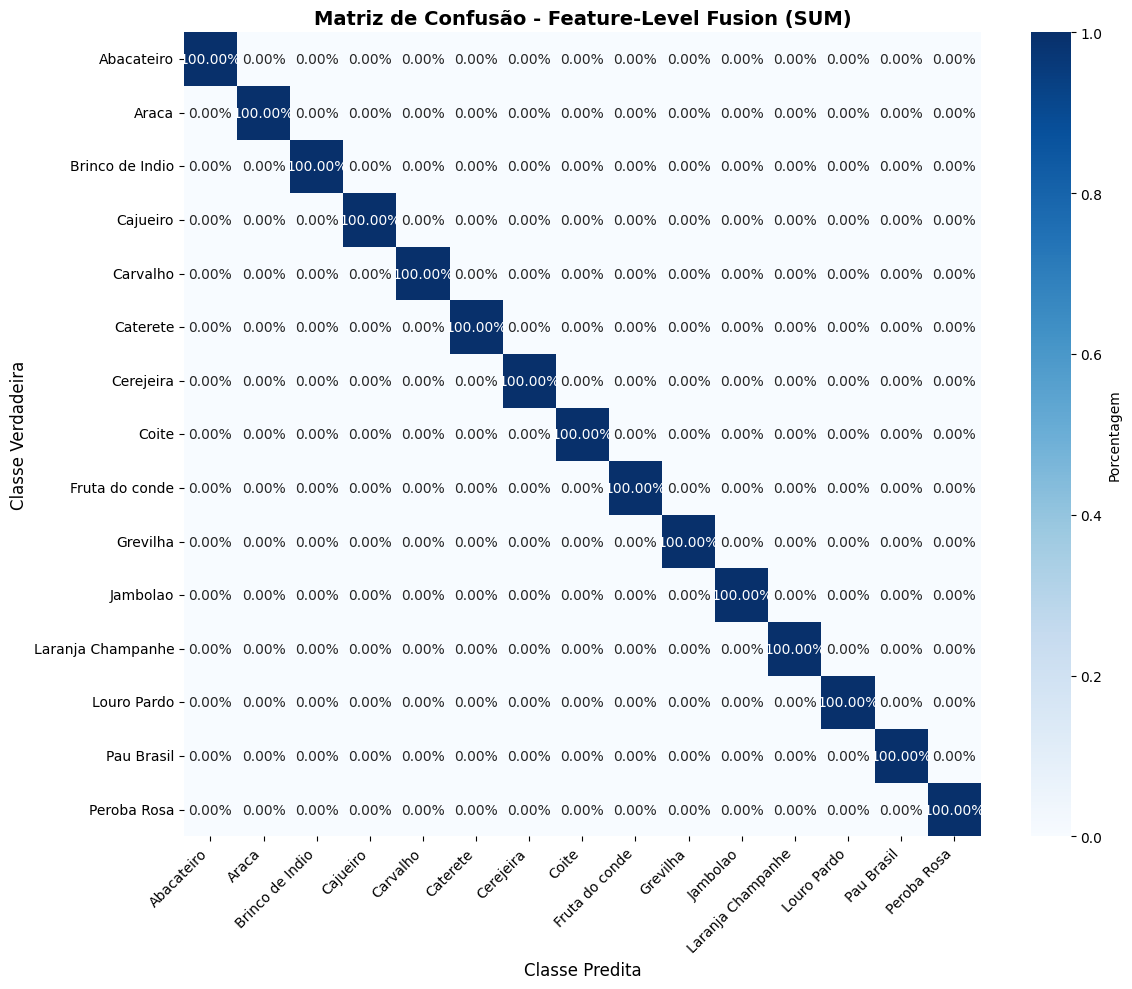



...Fim



In [15]:
# === Função Main ===
if __name__ == "__main__":
    try:
        print(
            "\n--------------- Treinamento do Modelo Híbrido 2 - MobileNetV4 ---------------"
            "\nInício..."
        )

        # 1. Dividir datasets originais
        ds_f = ImageFolderDataset(DATASET_FOLHA)
        print(f"Dataset de Folhas:\nClasses detectadas ({len(ds_f.class_to_idx.keys())}): {ds_f.class_to_idx.keys()}")
        print(f"Total de Imagens: {len(ds_f)}")
        train_f, valid_f, test_f = stratified_split(ds_f)
        print(f"Total: {len(train_f)+len(valid_f)+len(test_f)} | Treino: {len(train_f)} | Validação: {len(valid_f)} | Teste: {len(test_f)}\n")

        ds_c = ImageFolderDataset(DATASET_CASCA)
        print(f"Dataset de Cascas:\nClasses detectadas ({len(ds_c.class_to_idx.keys())}): {ds_c.class_to_idx.keys()}")
        print(f"Total de Imagens: {len(ds_c)}")
        train_c, valid_c, test_c = stratified_split(ds_c)
        print(f"Total: {len(train_c)+len(valid_c)+len(test_c)} | Treino: {len(train_c)} | Validação: {len(valid_c)} | Teste: {len(test_c)}\n")

        # 2. Criar produto cartesiano DEPOIS
        train_fusion = CartesianFusionDataset(train_f, train_c)
        valid_fusion = CartesianFusionDataset(valid_f, valid_c)
        test_fusion = CartesianFusionDataset(test_f, test_c)

        #fusion = CartesianFusionDataset(ds_f.dataset, ds_c.dataset)
        #train_fusion, valid_fusion, test_fusion = stratified_split(fusion)

        # Extra. Exibir dados do Dataset ---------------------------------------- DEBUG ------------------------------------------------------------------------------------------
        print(f"Total: {len(train_fusion)+len(valid_fusion)+len(test_fusion)} | Treino: {len(train_fusion)} | Validação: {len(valid_fusion)} | Teste: {len(test_fusion)}")

        print("\n=== DEBUG ===")

        # Verificar quantas classes estão presentes em cada split
        def check_classes(fusion_ds, name):
            classes_presentes = set()
            for _, _, label in fusion_ds.samples:
                classes_presentes.add(label)
            print(f"{name}: {len(classes_presentes)} classes presentes de 15 totais")
            print(f"Classes: {sorted(classes_presentes)}")
            return classes_presentes

        train_classes = check_classes(train_fusion, "Train")
        valid_classes = check_classes(valid_fusion, "Valid")
        test_classes = check_classes(test_fusion, "Test")

        # Verificar se há classes faltando
        all_classes = set(range(15))
        print(f"\nClasses faltando em train: {all_classes - train_classes}")
        print(f"Classes faltando em valid: {all_classes - valid_classes}")
        print(f"Classes faltando em test: {all_classes - test_classes}")

        # Pares por classe em cada split
        def count_pairs_per_class(fusion_ds, name):
            pares_por_classe = {}
            for _, _, label in fusion_ds.samples:
                pares_por_classe[label] = pares_por_classe.get(label, 0) + 1

            print(f"\n{name} - Pares por classe:")
            for label in sorted(pares_por_classe.keys()):
                print(f"  Classe {label}: {pares_por_classe[label]:4d} pares")
            print(f"Total: {sum(pares_por_classe.values())}")

        count_pairs_per_class(train_fusion, "TREINO")
        count_pairs_per_class(valid_fusion, "VALIDAÇÃO")
        count_pairs_per_class(test_fusion, "TESTE")

        # -------------------------------------------------------------------------------------------------------------------------------------------------------------------

        # 3. Criar DataLoaders
        train_loader = DataLoader(train_fusion, batch_size=BATCH_SIZE, shuffle=True)
        valid_loader = DataLoader(valid_fusion, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_fusion, batch_size=BATCH_SIZE, shuffle=False)

        # 🔹 Modelos base (feature extractors)
        model_f = create_feature_extractor(PESOS_FOLHA).to(DEVICE)
        model_c = create_feature_extractor(PESOS_CASCA).to(DEVICE)

        model_f.eval()
        model_c.eval()

        for p in model_f.parameters():
            p.requires_grad = False
        for p in model_c.parameters():
            p.requires_grad = False

        # 🔹 Dimensão das features
        #feat_dim = model_f.num_features
        # Descobre a dimensão real das features dinamicamente
        with torch.no_grad():
            dummy = torch.zeros(1, 3, INPUT_SIZE, INPUT_SIZE).to(DEVICE)
            feat_dim = model_f(dummy).shape[1]
        if FUSION_MODE == "concat":
            fusion_input_dim = feat_dim * 2
        else:  # sum
            fusion_input_dim = feat_dim

        # 🔹 Treinamento (somente MLP)
        print(f"\n{'='*80}")

        print(f"\n📊 Dimensão das features: {fusion_input_dim}")
        print(f"   Feature extractor: {model_f.num_features} features")
        print(f"   Fusion mode: {FUSION_MODE}")
        print(f"   MLP input: {fusion_input_dim} features\n")


        # 6. Obter nomes das classes
        class_names = list(ds_f.class_to_idx.keys())

        # 7. Grid Search
        lr_list    = [5e-4]#, 1e-4, 5e-5, 1e-5]
        epoch_list = [10]#, 20, 30]

        best_config, test_metrics = run_grid_search(
            model_f, model_c, fusion_input_dim,
            train_loader, valid_loader, test_loader,
            lr_list, epoch_list, class_names,
            patience=PATIENCE
        )

        print(f"{'='*80}\n")

        print("\n...Fim\n")

    except KeyboardInterrupt:
        print("\nPrograma encerrado via terminal...\n")